## Лабораторная работа №1 "Сравнение алгоритмов поиска подстроки в строке"
<br>
Выполнили: Панкратова Анжелла, Пьянзин Артём 18ПМИ-2

In [1]:
import codecs
from time import perf_counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Наивный алгоритм

In [2]:
def naive_matcher(text, pattern):
    operations = 0
    n = len(text)
    m = len(pattern)
    if m > n:
        return []
    for i in range(n - m + 1):
        j = 0
        while j < m:
            operations += 1
            if text[i + j] != pattern[j]:
                break
            j += 1
        if j == m:
            return (i, i + j - 1), operations

## Алгоритм Рабина-Карпа

In [3]:
def RK_matcher(text, pattern, q=117, d=256):
    operations = 0
    m = len(pattern)
    n = len(text)
    if m > n:
        return []
    pattHash = 0
    txtHash = 0
    h = pow(d, m - 1) % q
  
    for i in range(m):
        pattHash = (d * pattHash + ord(pattern[i])) % q
        txtHash = (d * txtHash + ord(text[i])) % q
  
    for i in range(n - m + 1):
        operations += 1 # hash comp
        if pattHash == txtHash:

            for j in range(m):
                operations += 1 # character comp
                if text[i + j] != pattern[j]:
                    break
                else: 
                    j += 1
            if j == m:
                return (i, i + m - 1), operations
                
        if i < n - m:
            txtHash = (d * (txtHash - ord(text[i]) * h) + ord(text[i + m])) %q
            if txtHash < 0:
                txtHash += q

## Алгоритм Бойера-Мура-Хорспула

In [4]:
def BMH_matcher(text, pattern):
    operations = 0
    m = len(pattern)
    n = len(text)
    if m > n:
        return []
    skip = []
    for k in range(2048): 
        skip.append(m)
    for k in range(m - 1): 
        skip[ord(pattern[k])] = m - k - 1
    skip = tuple(skip)
    k = m - 1
    while k < n:
        j = m - 1
        i = k
        while j >= 0 and text[i] == pattern[j]:
            operations += 1 # char comp
            j -= 1
            i -= 1
        operations += 1 # index comp
        if j == -1: 
            return (i + 1, i + m), operations
        k += skip[ord(text[k])]

## Алгоритм Кнута-Морриса-Пратта

In [5]:
def compute_prefix(pattern):
    m = len(pattern)
    pref_fun = [0] * len(pattern)
    k = 0
    for i in range(1, m):
        while k > 0 and pattern[k] != pattern[i]:
            k = pref_fun[k - 1]
        if pattern[k] == pattern[i]:
            k += 1
        pref_fun[i] = k
    return pref_fun

def KMP_matcher(text, pattern):
    operations = 0
    n = len(text)
    m = len(pattern)
    prefix_fun = compute_prefix(pattern)
    q = 0

    for i in range(n):
        while q > 0 and pattern[q] != text[i]:
            operations += 1
            q = prefix_fun[q - 1]
        operations += 1
        if pattern[q] == text[i]:
            q += 1
        if q == m:
            return (i + 1 - q, i), operations
#             q = prefix_fun[q - 1]

## Алгоритм Ахо-Корасика 

In [6]:
class AhoCorasick:
    def __init__(self, patterns):
        self.connections = {}
        self.fake_links = {}
        self.outputs = {}

        self.make_bor(patterns)
        self.make_links()

    def add_pattern(self, pattern):
        state = 0
        for j, char in enumerate(pattern):
            res = self.connections.get((state, char), -1)
            if res == -1:
                break
            state = res
        for char in pattern[j:]:
            self.new_state += 1
            self.connections[(state, char)] = self.new_state
            state = self.new_state
        self.outputs[state] = [pattern]

    def make_bor(self, patterns):
        self.new_state = 0
        if not isinstance(patterns, list):
            self.add_pattern(patterns)
        else:
            for pattern in patterns:
                self.add_pattern(pattern)

    def make_links(self):
        queue = []
        for (prev, char), to in self.connections.items():
            if prev == 0 and to != 0:
                queue.append(to)
                self.fake_links[to] = 0
        while queue:
            tmp = queue.pop(0)
            for (prev, char), to in self.connections.items():
                if prev == tmp:
                    queue.append(to)
                    state = self.fake_links[prev]
                    while 1:
                        result = self.connections.get((state, char), state and -1)
                        if result != -1:
                            break
                        state = self.fake_links[state]

                    fake = self.connections.get((state, char), state and -1)
                    self.fake_links[to] = fake
                    self.outputs.setdefault(to, []).extend(self.outputs.get(fake, []))

    def search(self, text):
        state = 0
        operations = 0
        for (i, char) in enumerate(text):
            while 1:
                result = self.connections.get((state, char), state and -1)
                operations += 1
                if result != -1:
                    state = result
                    break
                state = self.fake_links[state]

            for pattern in self.outputs.get(state, []):
                start_index = i - len(pattern) + 1
                return (start_index, i), operations
    
def AC_matcher(text, patterns):
    aho_corasick = AhoCorasick(patterns)
    return aho_corasick.search(text)

## Measurements of benchmark

In [12]:
results = pd.DataFrame(columns=['Filename', 'Алгоритм', 'Среднее_время', 'Число_операций', 'Длина_текста'])
algo_dict = {naive_matcher: 'Наивный', RK_matcher: 'Рабина-Карпа',
             BMH_matcher: 'Бойера-Мура-Хорспула', KMP_matcher: 'Кнута-Морриса-Пратта',
             AC_matcher: 'Ахо-Корасика'}

def measure_function(fun, text, pattern, expected, filename, iterations=100):
    global results
    total_time = 0
    for i in range(iterations):
        start = perf_counter()
        result = fun(text, pattern)
        if i == 0:
            if result[0] != expected:
                print("RESULT IS WRONG:", result, "EXPECTED:", expected)
            else:
                print('result:', result[0])
        end = perf_counter()
        total_time += (end - start)
    total_time /= iterations
    results = results.append({'Filename': filename, 'Алгоритм': algo_dict[fun],
                              'Среднее_время': total_time, 'Число_операций': result[1], 'Длина_текста': len(text)}, ignore_index=True)
    
    print('total time:', total_time)
    print('number of operations:', result[1], '\n')

def test(text, pattern, filename):
    expected = naive_matcher(text, pattern)[0]
    
    print('\tНаивный алгоритм')
    measure_function(naive_matcher, text, pattern, expected, filename)
    
    print("\tАлгоритм Рабина-Карпа" )
    measure_function(RK_matcher, text, pattern, expected, filename)
    
    print('\tАлгоритм Бойера-Мура-Хорспула')
    measure_function(BMH_matcher, text, pattern, expected, filename)
    
    print('\tАлгоритм Кнута-Морриса-Пратта')
    measure_function(KMP_matcher, text, pattern, expected, filename)
    
    print('\tАлгоритм Ахо-Карасика')
    measure_function(AC_matcher, text, pattern, expected, filename)
    
def start_testing():
    for bench_type in ['bad', 'good']:
        for i in range(1, 5):
            text = codecs.open(f"benchmarks/{bench_type}_t_{i}.txt", "r", "utf_8_sig")
            pattern = codecs.open(f"benchmarks/{bench_type}_w_{i}.txt", "r", "utf_8_sig")
            print(f'TEST FILE {bench_type} №{i}')
            test(text.read(), pattern.read(), f"{bench_type}_{i}")

In [13]:
start_testing()

TEST FILE bad №1
	Наивный алгоритм
result: (8, 9)
total time: 4.9310000005675645e-06
number of operations: 18 

	Алгоритм Рабина-Карпа
result: (8, 9)
total time: 8.583999999984826e-06
number of operations: 11 

	Алгоритм Бойера-Мура-Хорспула
result: (8, 9)
total time: 0.00027012499999983674
number of operations: 11 

	Алгоритм Кнута-Морриса-Пратта
result: (8, 9)
total time: 9.294000000465984e-06
number of operations: 18 

	Алгоритм Ахо-Карасика
result: (8, 9)
total time: 2.953499999904352e-05
number of operations: 18 

TEST FILE bad №2
	Наивный алгоритм
result: (90, 99)
total time: 0.000295933999998681
number of operations: 910 

	Алгоритм Рабина-Карпа
result: (90, 99)
total time: 0.00010145899999940865
number of operations: 101 

	Алгоритм Бойера-Мура-Хорспула
result: (90, 99)
total time: 0.00038376500000140366
number of operations: 101 

	Алгоритм Кнута-Морриса-Пратта
result: (90, 99)
total time: 8.921999999870422e-05
number of operations: 190 

	Алгоритм Ахо-Карасика
result: (90, 99

In [14]:
results

,Filename,Алгоритм,Среднее_время,Число_операций,Длина_текста
0,bad_1,Наивный,0.000005,18,10
1,bad_1,Рабина-Карпа,0.000009,11,10
2,bad_1,Бойера-Мура-Хорспула,0.000270,11,10
3,bad_1,Кнута-Морриса-Пратта,0.000009,18,10
4,bad_1,Ахо-Корасика,0.000030,18,10
5,bad_2,Наивный,0.000296,910,100
6,bad_2,Рабина-Карпа,0.000101,101,100
7,bad_2,Бойера-Мура-Хорспула,0.000384,101,100
8,bad_2,Кнута-Морриса-Пратта,0.000089,190,100
9,bad_2,Ахо-Корасика,0.000217,190,100


In [15]:
def draw(results):
    bad_files = results[results['Filename'].str.contains('bad')]
    good_files = results[results['Filename'].str.contains('good')]
    
    for files in [bad_files, good_files]:
        plt.figure(figsize = (15,10))
        plt.title('Среднее время работы алгоритмов')
        plt.xlabel('Длина текста')
        plt.ylabel('Среднее время работы')
        for alg in set(files['Алгоритм']):
            execution_time = list(files[files['Алгоритм'] == alg]['Среднее_время'])
            files_len = sorted(list(set(files['Длина_текста'])))
            plt.plot(files_len, execution_time, label = alg)
        plt.legend()
        plt.show()

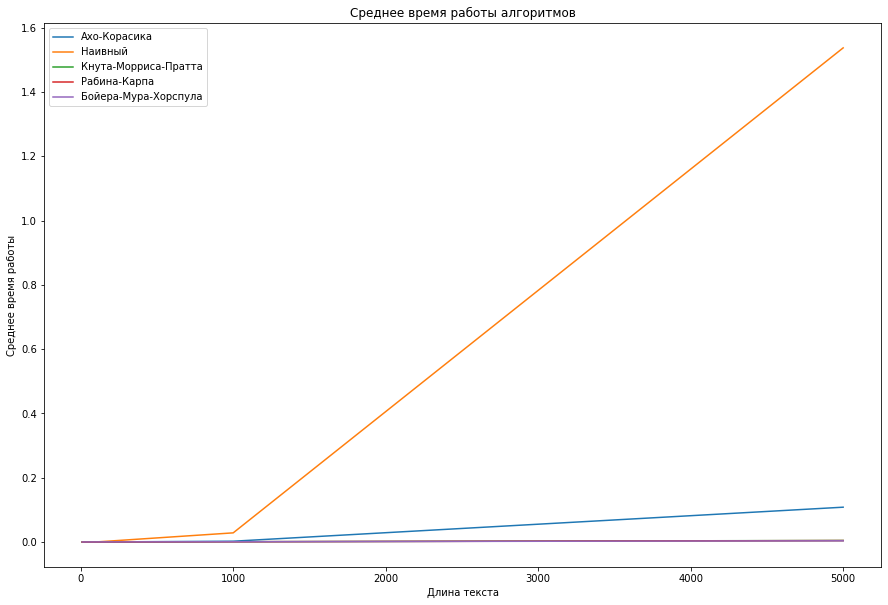

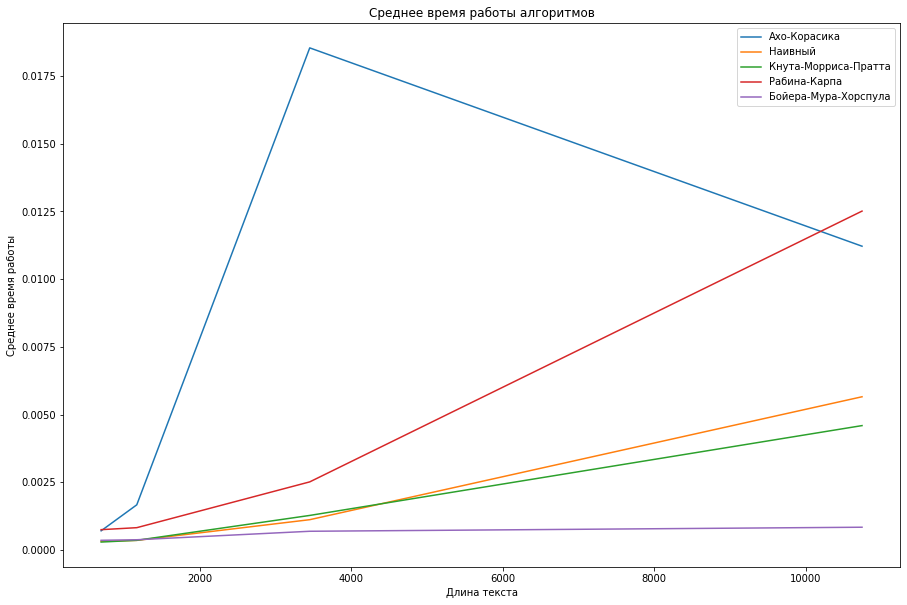

In [16]:
draw(results)